In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from itertools import chain
from sklearn.decomposition import PCA
from sklearn import decomposition
from sklearn import preprocessing 
import seaborn as sns
import cvxopt as co

In [14]:
data = pd.read_csv("../winequality-red.csv", sep=";")

print(data)

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4             0.700         0.00             1.9      0.076   
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
5               7.4             0.660         0.00             1.8      0.075   
6               7.9             0.600         0.06             1.6      0.069   
7               7.3             0.650         0.00             1.2      0.065   
8               7.8             0.580         0.02             2.0      0.073   
9               7.5             0.500         0.36             6.1      0.071   
10              6.7             0.580         0.08             1.8      0.097   
11              7.5         

/Users/akira/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3325: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1c616c50>,
      dtype=object)

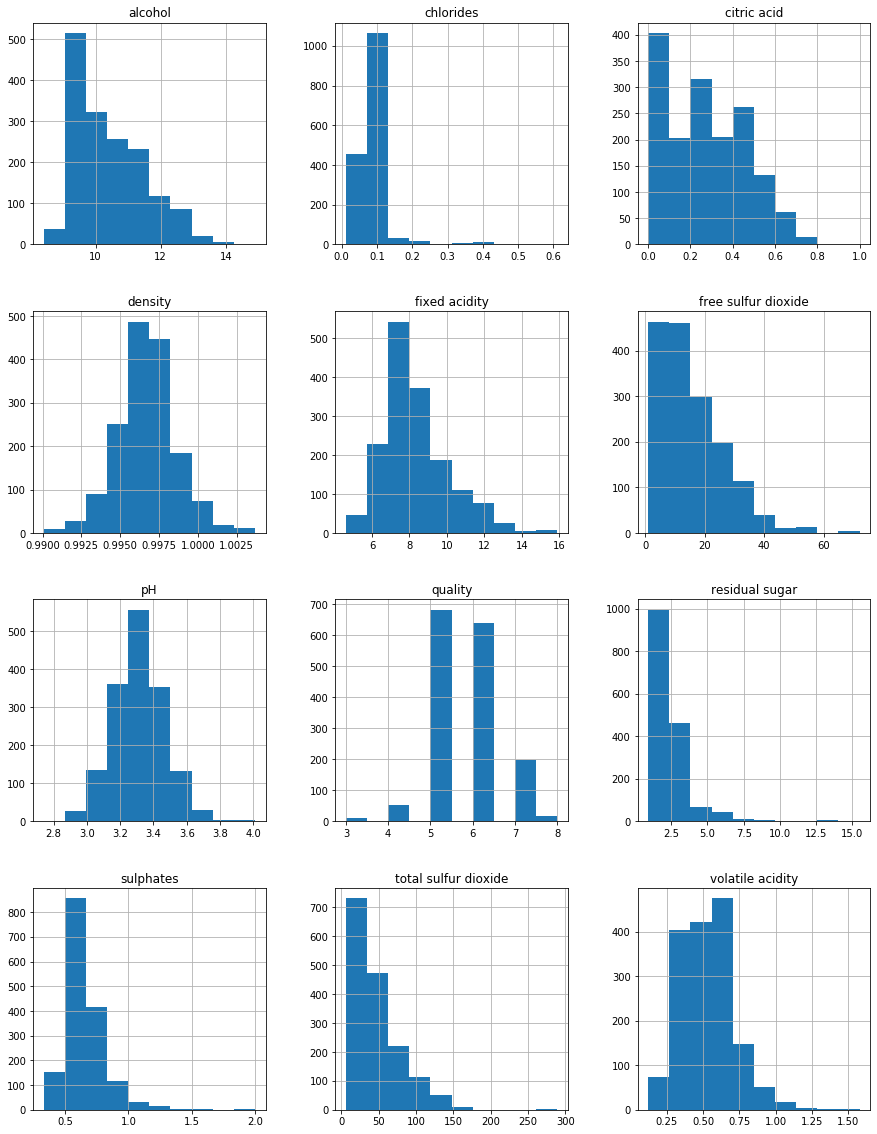

In [15]:
fig = plt.figure(figsize=(15, 20))
ax = fig.gca()
data.hist(ax = ax)

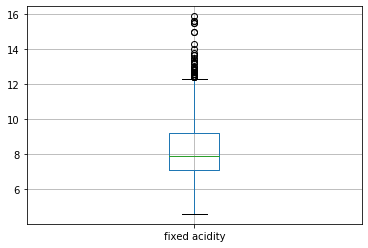

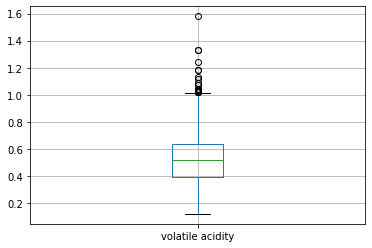

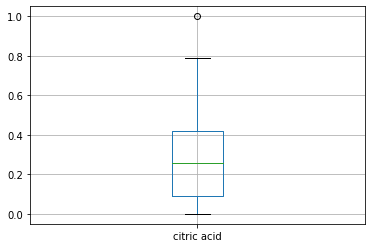

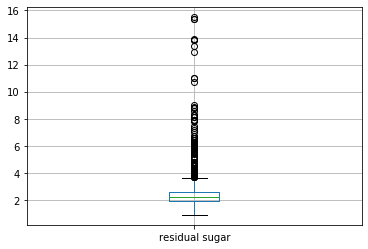

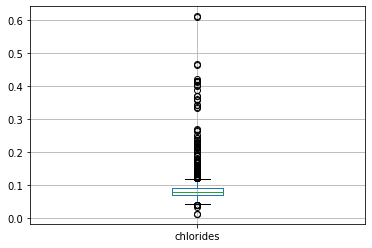

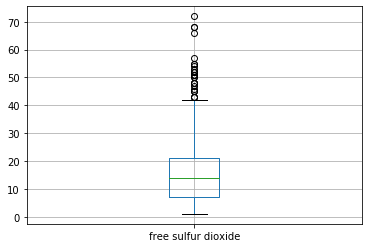

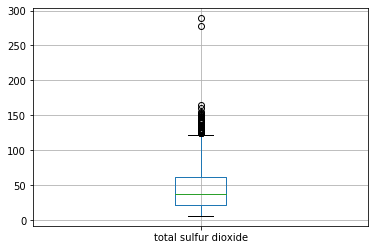

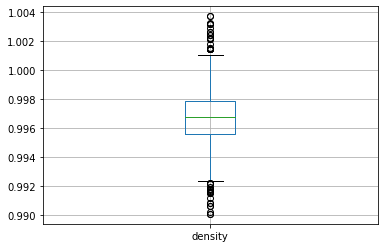

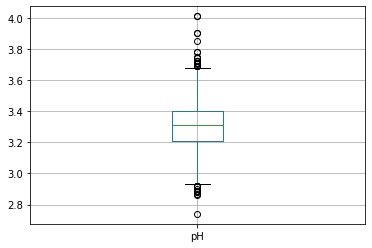

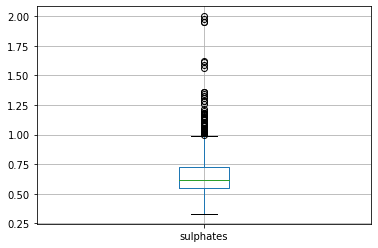

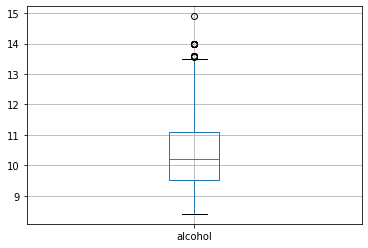

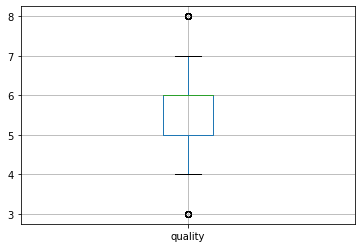

In [16]:
for col in data:
    plt.figure()
    data.boxplot([col])

In [17]:
data_without_quality = data.iloc[:,:-1]
col_drops = []
for col in data.columns:
    print(col)
    print(data[col].corr(data["quality"]))
    print(data[col].cov(data["quality"]))
    if abs(data[col].corr(data["quality"])) < 0.1:
                col_drops.append(col)
print(col_drops)
#     print(data[col].corr(data["quality"]))

fixed acidity
0.12405164911322429
0.17442358764590823
volatile acidity
-0.390557780264007
-0.056475883315683054
citric acid
0.22637251431804142
0.03561189291492415
residual sugar
0.013731637340066305
0.01563504568327674
chlorides
-0.12890655993005273
-0.0048995449283461764
free sulfur dioxide
-0.05065605724427631
-0.4279070695780605
total sulfur dioxide
-0.1851002889265378
-4.917237071667915
density
-0.17491922778334998
-0.0002666037049125685
pH
-0.057731391205382156
-0.0071978223248103275
sulphates
0.2513970790692613
0.034413408411546324
alcohol
0.4761663240011359
0.40978901081010416
quality
1.0
0.6521683999934252
['residual sugar', 'free sulfur dioxide', 'pH']


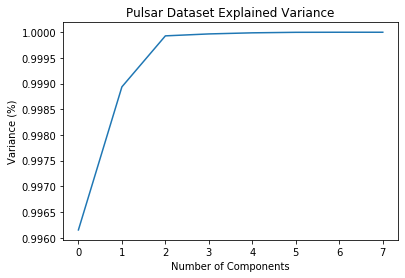

In [18]:
data_without_quality = data.iloc[:,:-1]
data_without_quality = data_without_quality.drop(col_drops, axis=1)
# print(data_without_quality)
pca = PCA().fit(data_without_quality)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

In [19]:
featureList = list(data)

redWineX = data[[featureList[i] for i in range(len(featureList) - 1)]]
redWineY = data[[featureList[-1]]]

for i in range(len(redWineY)):
    if redWineY.at[i, featureList[-1]] > 5:
        redWineY.at[i, featureList[-1]] = 1
    else:
        redWineY.at[i, featureList[-1]] = -1

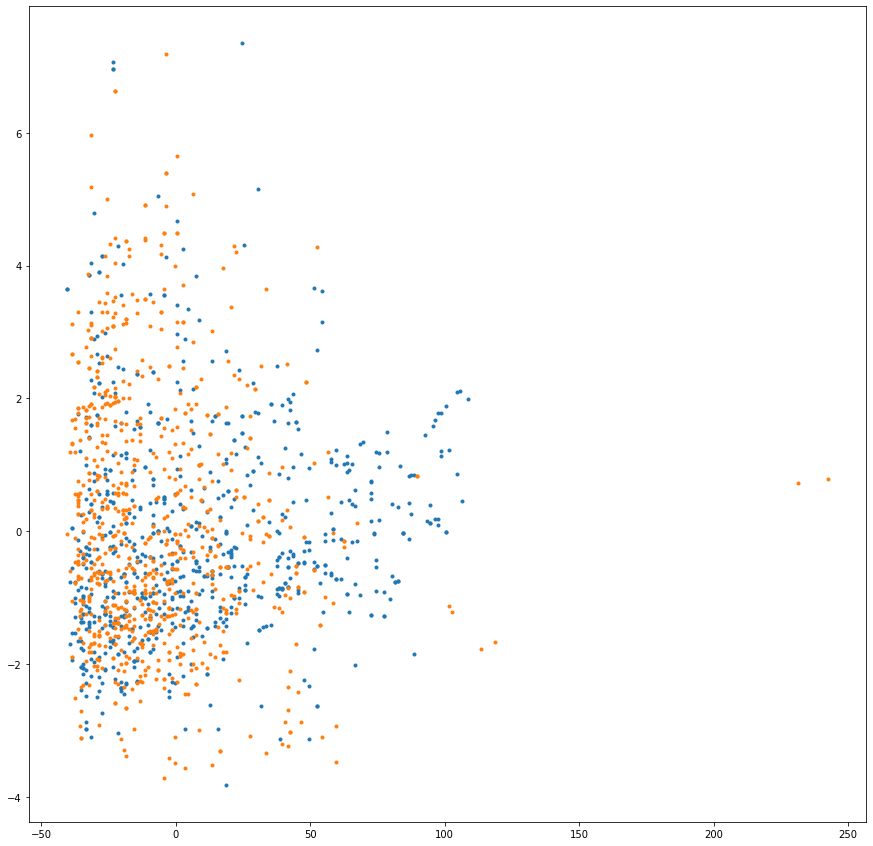

In [20]:
pca = decomposition.PCA(n_components=2)
pca.fit(data_without_quality)
X_trans = pca.transform(data_without_quality)
X_trans = pd.DataFrame(X_trans)
color = redWineY['quality']
X_trans['quality'] = color
fig = plt.figure(figsize=(15, 15))
ax = fig.gca()
groups = X_trans.groupby('quality')
for name, group in groups:
    ax.plot(group.iloc[:,0], group.iloc[:,1],marker='o',linestyle='',ms=3, label=name)
plt.show()

In [41]:
def percep_run(L,X,y):
    (n,d)=np.shape(X)
    theta = np.zeros((d, 1))
    for iter in range(0, L):
        all_points_classified_correctly = True
        for t in range(0, n):
            if (y[t] * (np.dot(X[t],  theta))[0]) <= 0:
                theta = theta + np.array([y[t]* X[t]]).T
                all_points_classified_correctly = False
        if all_points_classified_correctly:
            break

    return theta, iter+1

def svm_run(X, y):
    # Your code goes here
    H = np.identity(len(X[0]))
    f = np.zeros((len(X[0]), 1))
    A = np.array([ [-y[i] * X[i][j] for j in range(len(X[0]))] for i in range(len(X))]).reshape(len(X), len(X[0]))
    b = np.negative(np.ones((len(X), 1)))

    co.solvers.options['show_progress'] = False
    return np.array(co.solvers.qp(co.matrix(H, tc='d'), co.matrix(f, tc='d'),
                                  co.matrix(A, tc='d'), co.matrix(b, tc='d'))['x'])

def predict_run(theta, x):
# Input: numpy vector theta of d rows, 1 column
#        numpy vector x of d rows, 1 column
# Output: label (+1 or -1)
    dotp = np.dot(theta.T, x)
    if dotp > 0:
        return 1.
    else:
        return -1.

In [42]:
theta_perceptron, num = percep_run(10,data_without_quality.values,redWineY.values)

In [43]:
X = data_without_quality.values
y = redWineY.values
n, d = X.shape
# print(np.shape(y))
y_pred = np.zeros((n,1))
for i in range(n):
    all_except_i = [i for j in (range(i), range(i+1,n)) for i in j]
    X_train = X[all_except_i]
    y_train = y[all_except_i]
    print(np.shape(y_train))
    theta_fold = svm_run(X_train, y_train)
    y_pred[i] = predict_run(theta_fold, X[i])
err = np.mean(y!=y_pred)

(1598, 1)
(1598, 1)


ValueError: domain error